In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

In [2]:
x = torch.rand(10, 50)
w1 = nn.Parameter(torch.randn(128, 50))
w1

Parameter containing:
tensor([[ 0.0497,  1.0731, -0.1744,  ..., -0.6526, -1.8923, -0.8158],
        [ 0.1108, -0.8501, -1.1877,  ..., -0.8493, -0.7058,  1.2160],
        [-0.0202,  1.2600,  0.2232,  ...,  0.8280, -0.2250,  2.2446],
        ...,
        [-2.0572, -0.6883, -0.2730,  ..., -0.2288,  0.5536, -0.5518],
        [ 0.2751,  0.3319,  0.7248,  ..., -2.1691, -1.6186,  0.9455],
        [ 0.4286,  0.3999, -1.2376,  ...,  0.7571, -1.5101,  0.4962]],
       requires_grad=True)

In [3]:
w1.shape

torch.Size([128, 50])

In [4]:
w1.t().shape

torch.Size([50, 128])

In [5]:
y = x@w1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x50 and 128x50)

In [6]:
w2 = w1.t()
y = x@w2
y.shape

torch.Size([10, 128])

In [8]:
w3 = nn.Linear(128, 50)
print(w3.weight.shape, w3.weight.t().shape)

torch.Size([50, 128]) torch.Size([128, 50])


In [9]:
y = x@w3.weight
y.shape

torch.Size([10, 128])

## Tied weights with MNIST

In [11]:
import torchvision.transforms as T
from torchvision.datasets import MNIST

In [20]:
mnist_train = MNIST("../data", download=True, train=True, transform=T.Compose([T.ToTensor(), torch.flatten]))
mnist_test = MNIST("../data", train=False, download=True)

In [21]:
data_t = torch.tensor(np.array([data_label[0] for data_label in mnist_train]))
data_t.shape

torch.Size([60000, 784])

In [39]:
def create_model():
    class aenet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.input = nn.Linear(784, 128)
            self.enc = nn.Parameter(torch.randn(50, 128))
            self.dec = nn.Linear(128, 784)

        def forward(self, x):
            x = torch.relu(self.input(x))
            x = x.t()
            x = torch.relu(self.enc@x)
            x = torch.relu(self.enc.t()@x)
            x = x.t()
            y = torch.sigmoid(self.dec(x))
            return y
        
    net = aenet()
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer


In [40]:
## Test model
net, lossfunc, optimizer = create_model()
x = torch.rand([5, 784])
y = net(x)
x.shape, y.shape

(torch.Size([5, 784]), torch.Size([5, 784]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

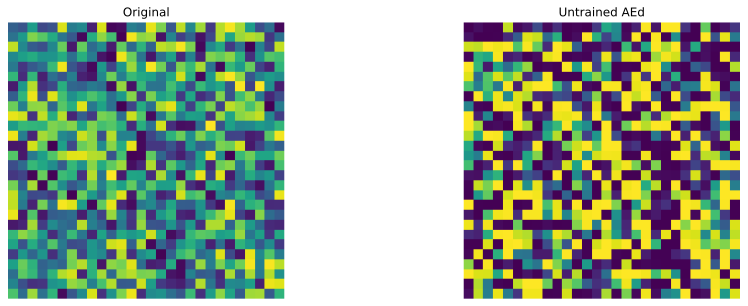

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(x[0].view(28, 28))
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(y[0].detach().view([28, 28]))
ax[1].set_title("Untrained AEd")
ax[1].axis("off")

In [42]:
batch_size = 32
epochs = 5
import sys
def train_model():
    net, lossfunc, optimizer = create_model()
    losses = [None] * epochs
    for ei in range(epochs):
        for i in range(int(data_t.shape[0]/batch_size)):
            x = data_t[i*batch_size:i*batch_size+batch_size]
            y = net(x)
            loss = lossfunc(y, x)
            losses[ei] = loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        sys.stdout.write("\r" + f"Epoch {ei+1}/{epochs}")
    return net, losses

In [43]:
net, losses = train_model()

Epoch 5/5

In [44]:
losses[-1]

0.01925550028681755

In [45]:
import copy
sample_img = data_t[12345].view([28, 28])
occluded_img = copy.deepcopy(sample_img)
occluded_img[10:13,:] = 1

y = net(data_t[12345])
trained_ae_img = y.detach().view([28, 28])

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

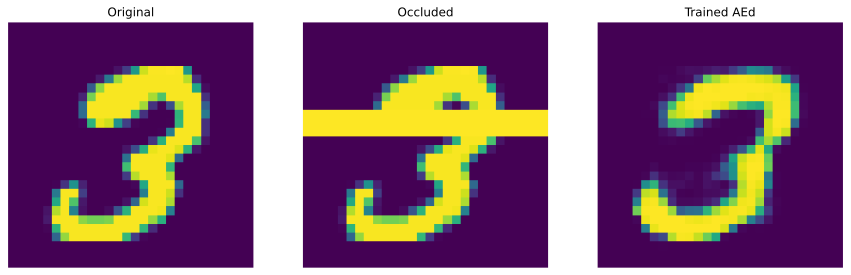

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_img)
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(occluded_img)
ax[1].set_title("Occluded")
ax[1].axis("off")
ax[2].imshow(y.detach().view([28, 28]))
ax[2].set_title("Trained AEd")
ax[2].axis("off")